In [81]:
# Import Libraries

import pandas as pd
import random
from faker import Faker
import json
import datetime
import os
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt

In [82]:
# Load Required Document Rules from Configuration File
with open("config.json") as f:
    config = json.load(f)
    
required_docs = set(config["required_documents"])

The list of mandatory documents is loaded that must be submitted with a claim like ID proof, claim form, medical bill. This list is stored in a configuration file (config.json). By using a config file, we can easily update the requirements in the future without changing the code.

In [83]:
# Generate Synthetic Policy and Claim Data for Testing

# Initialize the Faker library to generate fake data
fake = Faker()
Faker.seed(42)
random.seed(42)
num_records = 1000

# Generate policy data
policy_data = []
for i in range(1, num_records + 1):
    policy_number = f"P{1000 + i}"
    name = fake.name()
    status = random.choices(["Active", "Inactive"], weights=[0.8, 0.2])[0]
    max_amount = random.randint(5000, 20000)
    policy_data.append([policy_number, name, status, max_amount])

# Generate claims data based on policy_data
claim_data = []
for record in policy_data:
    policy_number, name, status, max_amount = record
    claim_id = f"C{policy_number[1:]}"
    claim_amount = random.randint(3000, max_amount + 5000)
    attached_docs = random.sample(list(required_docs), random.randint(2, 3))
    attached_docs_str = ", ".join(attached_docs)
    claim_data.append([claim_id, policy_number, name, claim_amount, attached_docs_str])

This creates a fake dataset to simulate a real-world insurance claims scenario. Using the Faker library a 1,000 policy records were generated, each with a unique policy number, customer name, status (active or inactive) and a maximum claimable amount. Then, for each policy a claim submission was simulated. Each claim includes a claim ID, amount requested and a random selection of 2–3 required documents.

In [84]:
# Convert the generated policy and claim lists into DataFrames
df_policies = pd.DataFrame(policy_data, columns=["PolicyNumber", "Name", "PolicyStatus", "MaxClaimAmount"])
df_claims = pd.DataFrame(claim_data, columns=["ClaimID", "PolicyNumber", "Name", "ClaimAmount", "AttachedDocs"])

policy_path_large = "C:/Users/moham/OneDrive/Documents/NCI/Sem 2/Intelligent Agents and Process Automation/Project/Dataset/policy_master_data.csv"
claims_path_large = "C:/Users/moham/OneDrive/Documents/NCI/Sem 2/Intelligent Agents and Process Automation/Project/Dataset/claims_submission_data.csv"
df_policies.to_csv(policy_path_large, index=False)
df_claims.to_csv(claims_path_large, index=False)

In [85]:
# Preview first few rows of the policy data
df_policies.head()

,PolicyNumber,Name,PolicyStatus,MaxClaimAmount
0,P1001,Allison Hill,Active,5409
1,P1002,Noah Rhodes,Active,9012
2,P1003,Angie Henderson,Active,17066
3,P1004,Daniel Wagner,Active,17135
4,P1005,Cristian Santos,Inactive,6424


In [86]:
# Preview the first few rows of the claims data
df_claims.head()

,ClaimID,PolicyNumber,Name,ClaimAmount,AttachedDocs
0,C1001,P1001,Allison Hill,5618,"Bill.pdf, ClaimForm.pdf, ID.pdf"
1,C1002,P1002,Noah Rhodes,7914,"Bill.pdf, ClaimForm.pdf"
2,C1003,P1003,Angie Henderson,14845,"ClaimForm.pdf, Bill.pdf"
3,C1004,P1004,Daniel Wagner,7550,"ID.pdf, ClaimForm.pdf"
4,C1005,P1005,Cristian Santos,8912,"ID.pdf, ClaimForm.pdf, Bill.pdf"


RULE-BASED MODEL

In [ ]:
# Load the claim and policy data from CSV files
claims_df = pd.read_csv("C:/Users/moham/OneDrive/Documents/NCI/Sem 2/Intelligent Agents and Process Automation/Project/Dataset/claims_submission_data.csv")
policies_df = pd.read_csv("C:/Users/moham/OneDrive/Documents/NCI/Sem 2/Intelligent Agents and Process Automation/Project/Dataset/policy_master_data.csv")
audit_log = []

# Define function to check claim eligibility
def check_eligibility(row):
    try:
        policy = policies_df[policies_df["PolicyNumber"] == row["PolicyNumber"]]
        policy_check = amount_check = doc_check = "Pass"
        timestamp = datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S")
        if policy.empty:
            audit_log.append([timestamp, row["ClaimID"], "Not Eligible", "Policy Not Found"])
            return "Not Eligible", "Policy Not Found", "Fail", "N/A", "N/A"
        policy_status = policy.iloc[0]["PolicyStatus"]
        max_amount = policy.iloc[0]["MaxClaimAmount"]
        if policy_status != "Active":
            audit_log.append([timestamp, row["ClaimID"], "Not Eligible", "Policy Inactive"])
            return "Not Eligible", "Policy Inactive", "Fail", "N/A", "N/A"
        if row["ClaimAmount"] > max_amount:
            audit_log.append([timestamp, row["ClaimID"], "Not Eligible", "Claim Exceeds Limit"])
            return "Not Eligible", "Claim Exceeds Limit", "Pass", "Fail", "N/A"
        attached_docs = set([doc.strip() for doc in row["AttachedDocs"].split(",")])
        if not required_docs.issubset(attached_docs):
            audit_log.append([timestamp, row["ClaimID"], "Not Eligible", "Missing Required Documents"])
            return "Not Eligible", "Missing Required Documents", "Pass", "Pass", "Fail"
        audit_log.append([timestamp, row["ClaimID"], "Eligible", "All Checks Passed"])
        return "Eligible", "All Checks Passed", "Pass", "Pass", "Pass"
    except Exception as e:
        audit_log.append([datetime.datetime.now().strftime("%Y-%m-%d %H:%M:%S"), row["ClaimID"], "Error", str(e)])
        return "Error", str(e), "Error", "Error", "Error"


check_eligibility() function is defined to automate the rule-based validation of each claim. It verifies whether the policy exists and is active, checks if the claim amount is within the allowed maximum and ensures all required documents are attached. Each decision outcome along with the reason and timestamp is recorded in an audit_log.

In [88]:
# Apply eligibility check
claims_df[["EligibilityStatus", "Reason", "PolicyCheck", "AmountCheck", "DocumentCheck"]] = claims_df.apply(lambda row: pd.Series(check_eligibility(row)), axis=1)

output_path = "C:/Users/moham/OneDrive/Documents/NCI/Sem 2/Intelligent Agents and Process Automation/Project/Outputs/claim_eligibility_results.csv"
claims_df.to_csv(output_path, index=False)
claims_df.head()

,ClaimID,PolicyNumber,Name,ClaimAmount,AttachedDocs,EligibilityStatus,Reason,PolicyCheck,AmountCheck,DocumentCheck
0,C1001,P1001,Allison Hill,5618,"Bill.pdf, ClaimForm.pdf, ID.pdf",Not Eligible,Claim Exceeds Limit,Pass,Fail,N/A
1,C1002,P1002,Noah Rhodes,7914,"Bill.pdf, ClaimForm.pdf",Not Eligible,Missing Required Documents,Pass,Pass,Fail
2,C1003,P1003,Angie Henderson,14845,"ClaimForm.pdf, Bill.pdf",Not Eligible,Missing Required Documents,Pass,Pass,Fail
3,C1004,P1004,Daniel Wagner,7550,"ID.pdf, ClaimForm.pdf",Not Eligible,Missing Required Documents,Pass,Pass,Fail
4,C1005,P1005,Cristian Santos,8912,"ID.pdf, ClaimForm.pdf, Bill.pdf",Not Eligible,Policy Inactive,Fail,N/A,N/A


This cell applies the eligibility check function to each claim in the dataset. It assigns the results of eligibility status, reason and validation checks into new columns. The final output is saved to a new CSV file.

In [89]:
# Create and Export Audit Log of Eligibility Decisions
audit_df = pd.DataFrame(audit_log, columns=["Timestamp", "ClaimID", "EligibilityStatus", "Reason"])
audit_df.to_csv("C:/Users/moham/OneDrive/Documents/NCI/Sem 2/Intelligent Agents and Process Automation/Project/Outputs/audit_log.csv", index=False)
audit_df.head()

,Timestamp,ClaimID,EligibilityStatus,Reason
0,2025-04-21 18:20:11,C1001,Not Eligible,Claim Exceeds Limit
1,2025-04-21 18:20:11,C1002,Not Eligible,Missing Required Documents
2,2025-04-21 18:20:11,C1003,Not Eligible,Missing Required Documents
3,2025-04-21 18:20:11,C1004,Not Eligible,Missing Required Documents
4,2025-04-21 18:20:11,C1005,Not Eligible,Policy Inactive


This creates an audit log that records every claim processed along with its timestamp, eligibility status and the reason for the decision. The log is saved as a separate CSV file.

In [90]:
# Summary Report of Claim Eligibility Results

total_claims = len(claims_df)
eligible = (claims_df["EligibilityStatus"] == "Eligible").sum()
not_eligible = (claims_df["EligibilityStatus"] == "Not Eligible").sum()

print("CLAIM ELIGIBILITY SUMMARY")
print(f"Total Claims Processed: {total_claims}")
print(f"Eligible Claims: {eligible}")
print(f"Not Eligible Claims: {not_eligible}")
print("\nTop Reasons for Ineligibility:")
print(claims_df[claims_df["EligibilityStatus"] == "Not Eligible"]["Reason"].value_counts())


CLAIM ELIGIBILITY SUMMARY
Total Claims Processed: 1000
Eligible Claims: 225
Not Eligible Claims: 775

Top Reasons for Ineligibility:
Reason
Claim Exceeds Limit           322
Missing Required Documents    246
Policy Inactive               207
Name: count, dtype: int64


This cell shows the summary of data. Out of 1,000 total claims, 225 were marked as Eligible and 775 were found to be Not Eligible based on defined business rules. The most common reasons for rejection were:
Claim Exceeds Limit – 322 cases
Missing Required Documents – 246 cases
Policy Inactive – 207 cases

In [91]:
# Email Notifications for Claim Eligibility Status
for index, row in claims_df.iterrows():
    print(f"""------------------------------------------------------------
    To: {row['Name']}
    Subject: Insurance Claim {row['ClaimID']} - Status Update

    Dear {row['Name']},

    Thank you for submitting your claim with us. We have completed the initial review of your claim request with ID: {row['ClaimID']}.

    Claim Status: {row['EligibilityStatus']}
    Reason: {row['Reason']}

    If you have any questions or need further assistance, please feel free to contact our support team.

    Best regards,  
    Insurance Claims Processing Team  
    ------------------------------------------------------------""")


------------------------------------------------------------
    To: Allison Hill
    Subject: Insurance Claim C1001 - Status Update

    Dear Allison Hill,

    Thank you for submitting your claim with us. We have completed the initial review of your claim request with ID: C1001.

    Claim Status: Not Eligible
    Reason: Claim Exceeds Limit

    If you have any questions or need further assistance, please feel free to contact our support team.

    Best regards,  
    Insurance Claims Processing Team  
    ------------------------------------------------------------
------------------------------------------------------------
    To: Noah Rhodes
    Subject: Insurance Claim C1002 - Status Update

    Dear Noah Rhodes,

    Thank you for submitting your claim with us. We have completed the initial review of your claim request with ID: C1002.

    Claim Status: Not Eligible
    Reason: Missing Required Documents

    If you have any questions or need further assistance, please feel fr

In [ ]:
# Claim Status Search Tool

# Define a function to read each claim
def get_claim_stage(row):
    if row["EligibilityStatus"] == "Eligible":
        return "Eligible - Awaiting Final Approval"
    else:
        return "Rejected - Not Eligible"

claims_df["ClaimStage"] = claims_df.apply(get_claim_stage, axis=1)
print("Type a Policy Number or Claim ID to view details.\n")
os.system('cls' if os.name == 'nt' else 'clear')

while True:
    search_id = input("Enter Policy Number or Claim ID (or 'exit' to quit): ").strip()
    if search_id.lower() == 'exit':
        print("Exit")
        break
    os.system('cls' if os.name == 'nt' else 'clear')
    result = claims_df[(claims_df["PolicyNumber"] == search_id) | (claims_df["ClaimID"] == search_id)]
    if not result.empty:
        latest = result.iloc[-1]
        print(f"""------------------------------------------------------------
        Claim Lookup Result:
        Customer Name    : {latest['Name']}
        Policy Number    : {latest['PolicyNumber']}
        Claim ID         : {latest['ClaimID']}
        Claim Amount     : ₹{latest['ClaimAmount']}
        Eligibility      : {latest['EligibilityStatus']}
        Reason           : {latest['Reason']}
        Current Stage : {latest['ClaimStage']}
        ------------------------------------------------------------""")
    else:
        print("No matching record found. Please check the ID and try again.")


Type a Policy Number or Claim ID to view details.

------------------------------------------------------------
        Claim Lookup Result:
        Customer Name    : Noah Rhodes
        Policy Number    : P1002
        Claim ID         : C1002
        Claim Amount     : ₹7914
        Eligibility      : Not Eligible
        Reason           : Missing Required Documents
        Current Stage : Rejected - Not Eligible
        ------------------------------------------------------------
------------------------------------------------------------
        Claim Lookup Result:
        Customer Name    : Abigail Shaffer
        Policy Number    : P1007
        Claim ID         : C1007
        Claim Amount     : ₹9708
        Eligibility      : Not Eligible
        Reason           : Claim Exceeds Limit
        Current Stage : Rejected - Not Eligible
        ------------------------------------------------------------
------------------------------------------------------------
        Claim

This interactive tool allows users to search for claim information using either a Policy Number or Claim ID.

MACHINE LEARNING MODELS

In [94]:
# Recreate the ML dataset again

# Generate policy data
policy_data = []
for i in range(1000):
    policy_number = f"P{1000 + i}"
    name = fake.name()
    policy_status = random.choices(["Active", "Inactive"], weights=[0.8, 0.2])[0]
    max_claim = random.randint(5000, 20000)
    policy_data.append([policy_number, name, policy_status, max_claim])

# Generate claims data
claim_data = []
for policy in policy_data:
    policy_number, name, status, max_claim = policy
    claim_id = f"C{policy_number[1:]}"
    claim_amount = random.randint(3000, max_claim + 5000)
    attached_docs = random.sample(list(required_docs), random.randint(2, 3))
    attached_docs_str = ", ".join(attached_docs)
    eligible = 1 if status == "Active" and claim_amount <= max_claim and required_docs.issubset(set(attached_docs)) else 0
    doc_score = len(required_docs.intersection(set(attached_docs)))
    claim_data.append([claim_id, policy_number, name, claim_amount, attached_docs_str, status, max_claim, doc_score, eligible])


columns = ["ClaimID", "PolicyNumber", "Name", "ClaimAmount", "AttachedDocs", "PolicyStatus", "MaxClaimAmount", "DocumentScore", "WasEligible"]
ml_df = pd.DataFrame(claim_data, columns=columns)
dataset_path = "C:/Users/moham/OneDrive/Documents/NCI/Sem 2/Intelligent Agents and Process Automation/Project/Dataset/ml_claims_dataset.csv"
ml_df.to_csv(dataset_path, index=False)
ml_df.head()


,ClaimID,PolicyNumber,Name,ClaimAmount,AttachedDocs,PolicyStatus,MaxClaimAmount,DocumentScore,WasEligible
0,C1000,P1000,Matthew Davis MD,9910,"ID.pdf, Bill.pdf",Active,12530,2,0
1,C1001,P1001,Stephen Wood,6532,"Bill.pdf, ID.pdf",Active,9750,2,0
2,C1002,P1002,Dennis Marshall,3034,"Bill.pdf, ID.pdf",Active,7893,2,0
3,C1003,P1003,Derrick Brown,4106,"ID.pdf, Bill.pdf",Active,11294,2,0
4,C1004,P1004,Mary Miller,12389,"Bill.pdf, ID.pdf, ClaimForm.pdf",Active,9896,3,0


This block generates a synthetic dataset for training ML models by simulating insurance policies and claim submissions. It includes random customer data, attached documents and eligibility labels based on rule-based conditions. The final dataset is saved for use in machine learning classification.

In [95]:
# Load ML Dataset and Prepare Features for Model Training

ml_df = pd.read_csv("C:/Users/moham/OneDrive/Documents/NCI/Sem 2/Intelligent Agents and Process Automation/Project/Dataset/ml_claims_dataset.csv")
ml_df["PolicyStatusEncoded"] = ml_df["PolicyStatus"].map({"Active": 1, "Inactive": 0})
feature_cols = ["ClaimAmount", "MaxClaimAmount", "DocumentScore", "PolicyStatusEncoded"]
X = ml_df[feature_cols]
y = ml_df["WasEligible"]

# Split into train and test data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)
print("Training samples:", X_train.shape[0])
print("Test samples    :", X_test.shape[0])
print("Features used:", feature_cols)


Training samples: 700
Test samples    : 300
Features used: ['ClaimAmount', 'MaxClaimAmount', 'DocumentScore', 'PolicyStatusEncoded']


This cell loads the generated ML dataset and prepares it for model training. It encodes the policy status, selects key features like claim amount and document score and splits the data into training and test sets for evaluation.


Model: Logistic Regression
Accuracy: 0.9566666666666667
Classification Report:
               precision    recall  f1-score   support

           0       0.96      0.98      0.97       233
           1       0.94      0.87      0.90        67

    accuracy                           0.96       300
   macro avg       0.95      0.92      0.94       300
weighted avg       0.96      0.96      0.96       300

Confusion Matrix:


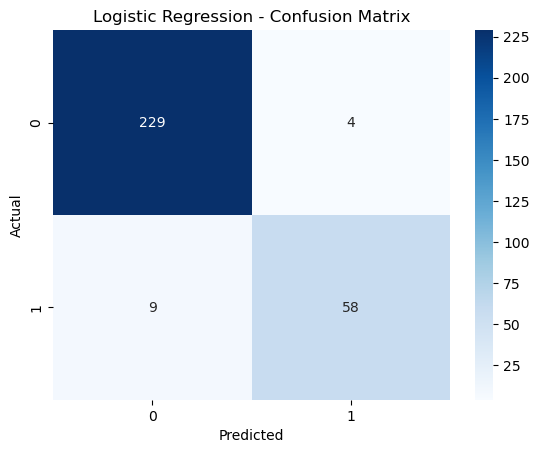

In [97]:
# Logistic Regression

# Train Model
log_model = LogisticRegression(max_iter=1000)
log_model.fit(X_train, y_train)
log_preds = log_model.predict(X_test)

# Define Evaluation Function
def evaluate_model(name, y_true, y_pred):
    print(f"\nModel: {name}")
    print("Accuracy:", accuracy_score(y_true, y_pred))
    print("Classification Report:\n", classification_report(y_true, y_pred))
    print("Confusion Matrix:")
    sns.heatmap(confusion_matrix(y_true, y_pred), annot=True, fmt="d", cmap="Blues")
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.show()

evaluate_model("Logistic Regression", y_test, log_preds)

This trains a Logistic Regression model to predict claim eligibility. The model achieved accuracy of 95.67% by correctly classifying most cases. The confusion matrix shows strong performance especially for non-eligible claims with only a few misclassifications.


Model: Decision Tree
Accuracy: 0.9766666666666667
Classification Report:
               precision    recall  f1-score   support

           0       0.97      1.00      0.99       233
           1       0.98      0.91      0.95        67

    accuracy                           0.98       300
   macro avg       0.98      0.95      0.97       300
weighted avg       0.98      0.98      0.98       300

Confusion Matrix:


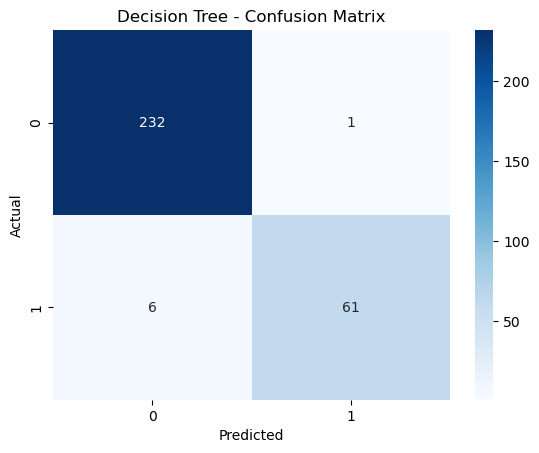

In [98]:
# Decision Tree
tree_model = DecisionTreeClassifier(random_state=42)
tree_model.fit(X_train, y_train)
tree_preds = tree_model.predict(X_test)
evaluate_model("Decision Tree", y_test, tree_preds)

The Decision Tree model showed an accuracy of 97.67%. It correctly classified almost all claims including a high number of eligible ones. The confusion matrix shows only a few misclassifications.


Model: Random Forest
Accuracy: 0.9833333333333333
Classification Report:
               precision    recall  f1-score   support

           0       0.98      1.00      0.99       233
           1       0.98      0.94      0.96        67

    accuracy                           0.98       300
   macro avg       0.98      0.97      0.98       300
weighted avg       0.98      0.98      0.98       300

Confusion Matrix:


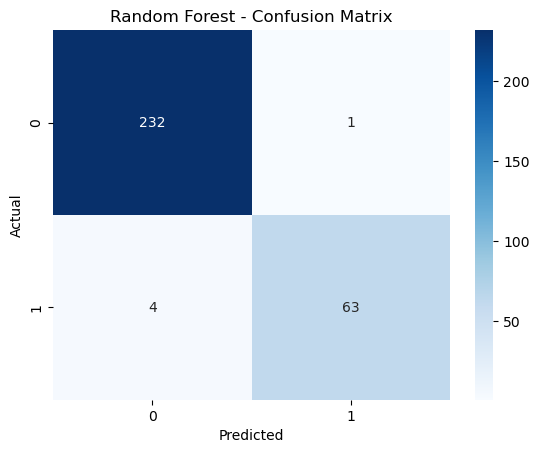

In [99]:
# Random Forest
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)
rf_preds = rf_model.predict(X_test)
evaluate_model("Random Forest", y_test, rf_preds)

The Random Forest model delivered the highest accuracy of 98.33% among all tested models. It correctly identified nearly all eligible and ineligible claims with minimal misclassifications. This makes it the most reliable and accurate choice for automating claim eligibility predictions in this project.

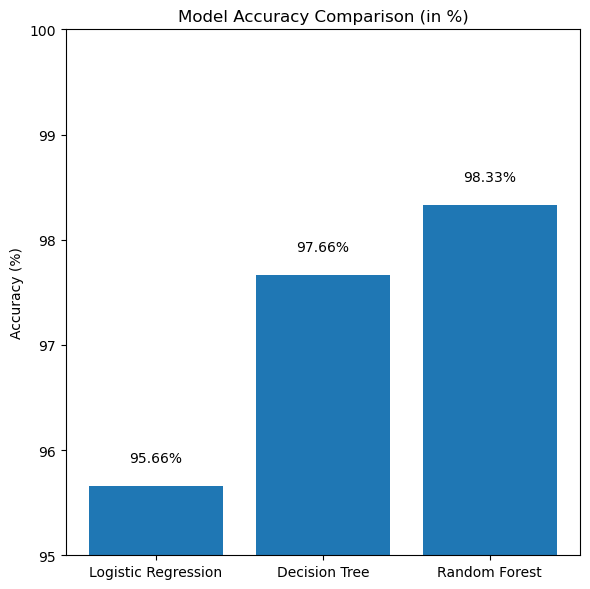

In [101]:
# Compare Model with bar chart based on Accuracy scores
accuracy_scores = {"Logistic Regression": 0.9566, "Decision Tree": 0.9766, "Random Forest": 0.9833}

plt.figure(figsize=(6, 6))
bars = plt.bar(accuracy_scores.keys(), [v * 100 for v in accuracy_scores.values()])
for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + bar.get_width() / 2, yval + 0.2, f"{yval:.2f}%", ha='center', va='bottom')

plt.ylim(95, 100)
plt.ylabel("Accuracy (%)")
plt.title("Model Accuracy Comparison (in %)")
plt.tight_layout()
plt.show()

The bar chart clearly shows that the Random Forest model performed the best with the highest accuracy (98.33%) followed by Decision Tree (97.66%) and Logistic Regression (95.66%). This visual comparison supports selecting Random Forest for intelligent claim eligibility prediction due to its superior performance.